[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/ltf_visualization.ipynb)

# Linear Threshold Functions: Geometry and Intuition

**Based on**: O'Donnell, *Analysis of Boolean Functions*, Chapter 5

A **Linear Threshold Function (LTF)** is defined as:
$$f(x) = \text{sign}(w_1 x_1 + w_2 x_2 + \cdots + w_n x_n - \theta)$$

Geometrically, this is a **hyperplane** cutting through the Boolean hypercube $\{-1, +1\}^n$.

This notebook provides interactive 3D visualizations to build intuition for:
1. How hyperplanes partition the hypercube
2. The relationship between weights and influences
3. Chow parameters and the uniqueness theorem
4. Regular vs irregular LTFs

---

In [1]:
# Install/upgrade boofun (required for Colab)
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import warnings
warnings.filterwarnings('ignore')

# For better 3D plots
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 11

---
## 1. The Boolean Hypercube in 3D

In $n=3$ dimensions, the Boolean hypercube $\{-1, +1\}^3$ has 8 vertices (corners of a cube).

An LTF with weights $(w_1, w_2, w_3)$ and threshold $\theta$ defines the hyperplane:
$$w_1 x_1 + w_2 x_2 + w_3 x_3 = \theta$$

Points on one side of the plane output $+1$, points on the other side output $-1$.

In [3]:
def plot_hypercube_with_hyperplane(weights, threshold, title="LTF Hyperplane", elev=20, azim=45):
    """
    Visualize a 3D hypercube with the LTF hyperplane cutting through it.
    
    Args:
        weights: [w1, w2, w3] weight vector
        threshold: threshold value theta
        title: plot title
        elev, azim: viewing angles
    """
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Generate all 8 vertices of the hypercube {-1, +1}^3
    vertices = np.array([[-1,-1,-1], [-1,-1,1], [-1,1,-1], [-1,1,1],
                         [1,-1,-1], [1,-1,1], [1,1,-1], [1,1,1]])
    
    # Classify each vertex
    w = np.array(weights)
    classifications = np.sign(vertices @ w - threshold)
    classifications[classifications == 0] = 1  # tie-break
    
    # Plot vertices with colors based on classification
    for i, (v, c) in enumerate(zip(vertices, classifications)):
        color = 'blue' if c > 0 else 'red'
        marker = 'o' if c > 0 else 's'
        label_text = f'({int(v[0])},{int(v[1])},{int(v[2])})'
        ax.scatter(*v, c=color, s=200, marker=marker, edgecolors='black', linewidth=2)
        ax.text(v[0]*1.15, v[1]*1.15, v[2]*1.15, label_text, fontsize=9)
    
    # Draw edges of the hypercube
    edges = [
        [0,1], [0,2], [0,4], [1,3], [1,5], [2,3], [2,6], [3,7],
        [4,5], [4,6], [5,7], [6,7]
    ]
    for e in edges:
        pts = vertices[e]
        ax.plot3D(*pts.T, 'gray', alpha=0.5, linewidth=1)
    
    # Draw the hyperplane (within the cube bounds)
    # Plane: w1*x + w2*y + w3*z = theta
    # Solve for z: z = (theta - w1*x - w2*y) / w3 if w3 != 0
    xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 30), np.linspace(-1.5, 1.5, 30))
    
    if abs(w[2]) > 1e-10:
        zz = (threshold - w[0]*xx - w[1]*yy) / w[2]
        # Clip to cube bounds
        mask = (zz >= -1.5) & (zz <= 1.5)
        zz = np.where(mask, zz, np.nan)
        ax.plot_surface(xx, yy, zz, alpha=0.3, color='green', edgecolor='none')
    elif abs(w[1]) > 1e-10:
        yy_plane = (threshold - w[0]*xx) / w[1]
        zz = np.linspace(-1.5, 1.5, 30)
        # Different handling for y-aligned planes
    
    # Add normal vector from origin
    w_norm = w / np.linalg.norm(w) * 1.2
    ax.quiver(0, 0, 0, w_norm[0], w_norm[1], w_norm[2], 
              color='darkgreen', arrow_length_ratio=0.1, linewidth=3)
    ax.text(w_norm[0]*1.1, w_norm[1]*1.1, w_norm[2]*1.1, 'w', fontsize=12, fontweight='bold')
    
    # Labels and formatting
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_ylabel('$x_2$', fontsize=12)
    ax.set_zlabel('$x_3$', fontsize=12)
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.view_init(elev=elev, azim=azim)
    
    # Count outputs
    n_pos = np.sum(classifications > 0)
    n_neg = np.sum(classifications < 0)
    
    ax.set_title(f"{title}\nweights={weights}, theta={threshold}\n" +
                 f"Blue (+1): {n_pos} vertices, Red (-1): {n_neg} vertices", fontsize=12)
    
    plt.tight_layout()
    return fig, ax

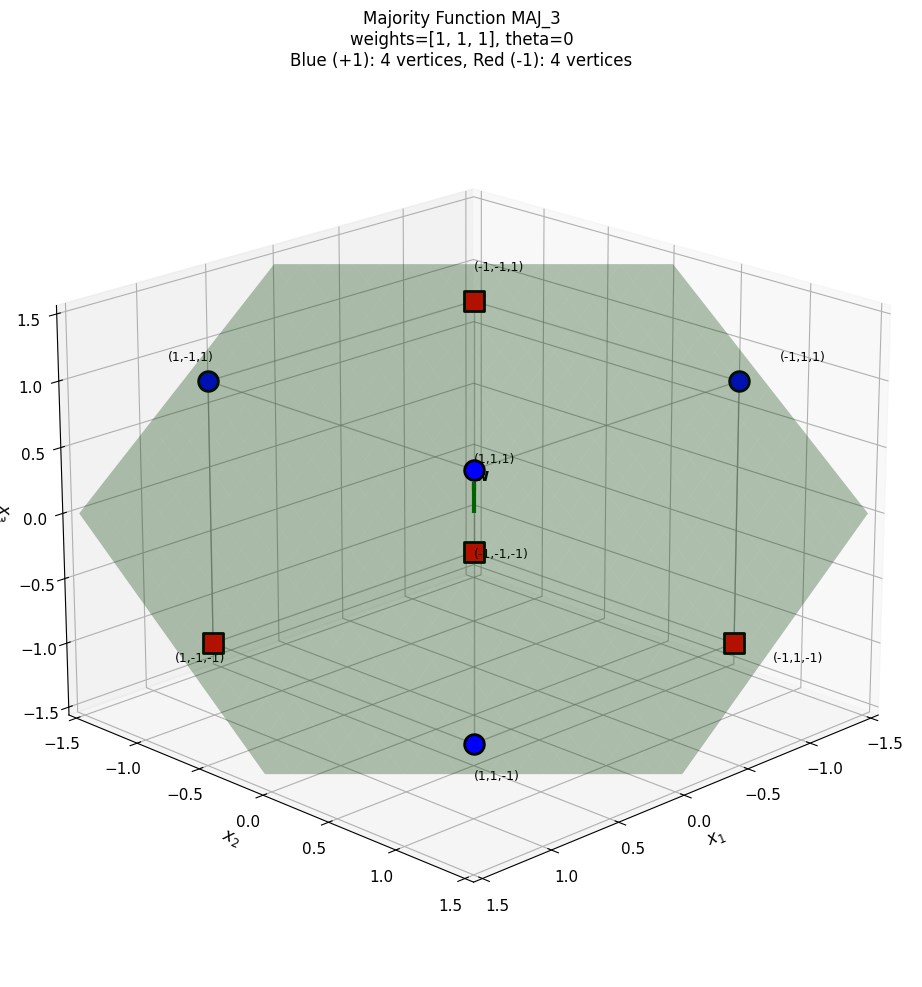

In [4]:
# Majority function: MAJ_3(x) = sign(x1 + x2 + x3)
plot_hypercube_with_hyperplane([1, 1, 1], 0, "Majority Function MAJ_3")
plt.show()

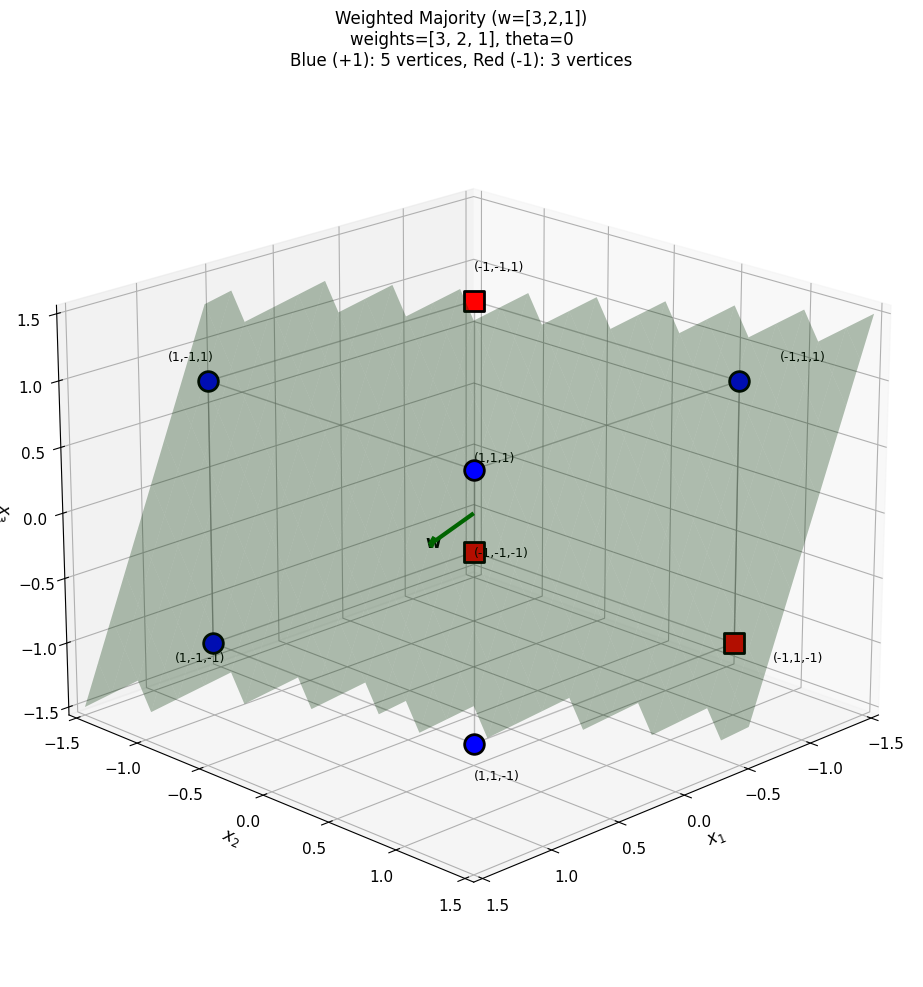

In [5]:
# Weighted majority with different weights
plot_hypercube_with_hyperplane([3, 2, 1], 0, "Weighted Majority (w=[3,2,1])")
plt.show()

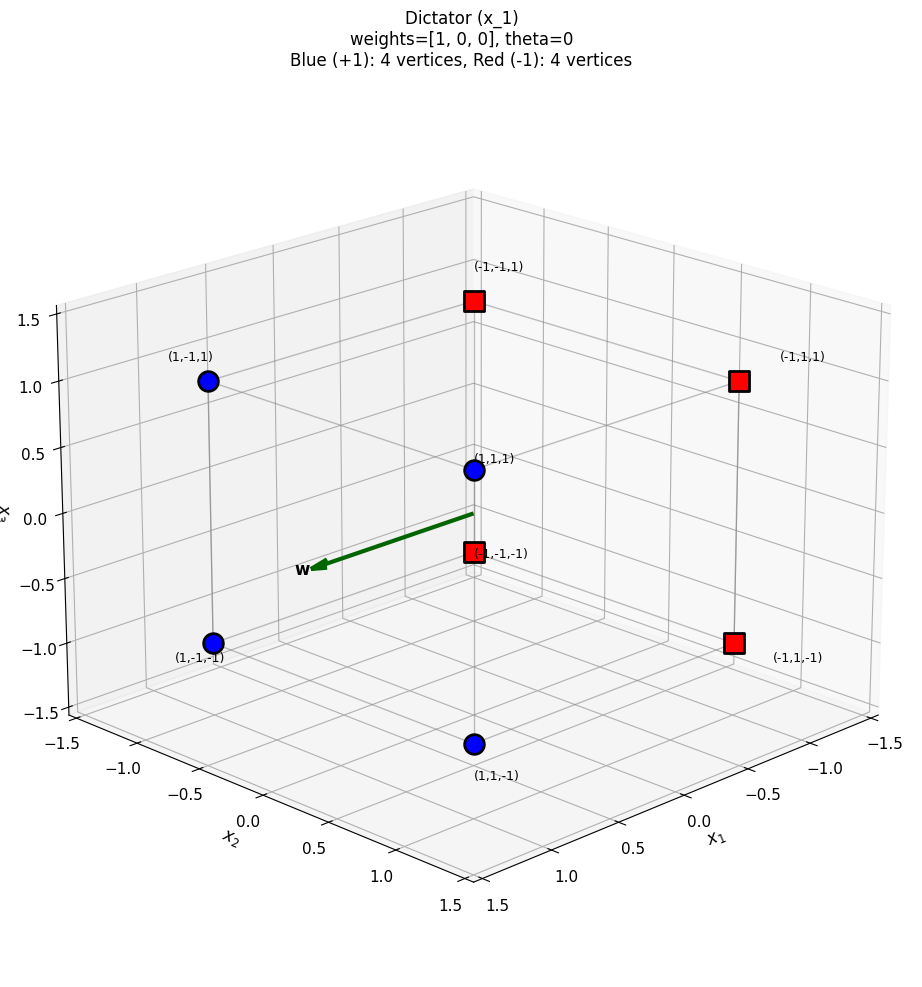

In [6]:
# Dictator: f(x) = x1 (only first variable matters)
plot_hypercube_with_hyperplane([1, 0, 0], 0, "Dictator (x_1)")
plt.show()

---
## 2. LTF Influences and Weight Relationship

For an LTF $f(x) = \text{sign}(w \cdot x - \theta)$, the **influence** of variable $i$ is:
$$\text{Inf}_i[f] = \Pr_{x \sim \{-1,+1\}^n}[f(x) \neq f(x^{\oplus i})]$$

**Key insight**: Variables with larger weights have higher influence. The hyperplane is "more perpendicular" to high-weight directions.

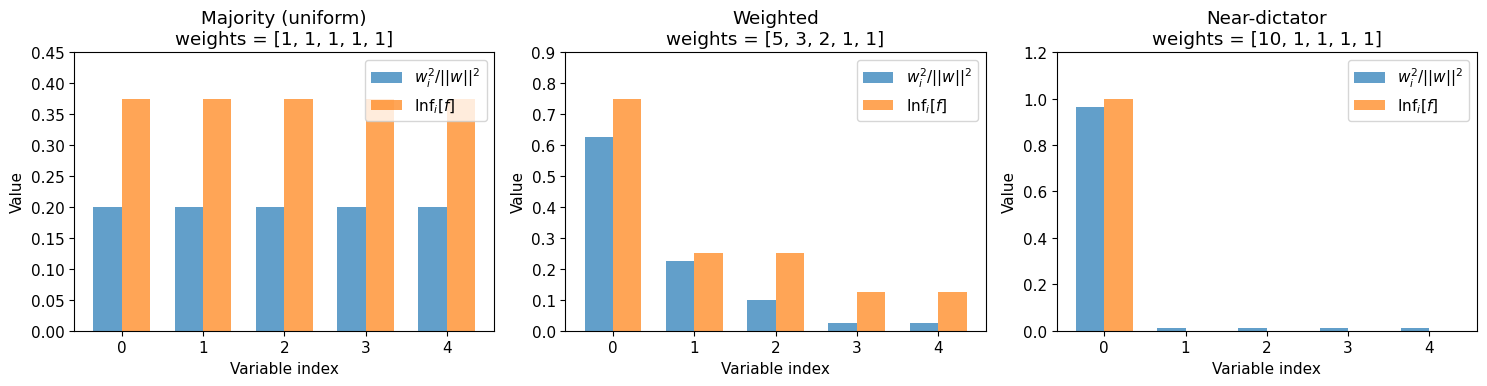

In [7]:
def compare_ltf_influences(weight_configs):
    """Compare influences for different LTF weight configurations."""
    fig, axes = plt.subplots(1, len(weight_configs), figsize=(5*len(weight_configs), 4))
    if len(weight_configs) == 1:
        axes = [axes]
    
    for ax, (weights, name) in zip(axes, weight_configs):
        # Create LTF
        ltf = bf.weighted_majority(weights)
        infs = ltf.influences()
        
        # Normalize weights for comparison
        w = np.array(weights, dtype=float)
        w_norm = w / np.linalg.norm(w)
        
        x = np.arange(len(weights))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, w_norm**2, width, label='$w_i^2/||w||^2$', alpha=0.7)
        bars2 = ax.bar(x + width/2, infs, width, label='$\\mathrm{Inf}_i[f]$', alpha=0.7)
        
        ax.set_xlabel('Variable index')
        ax.set_ylabel('Value')
        ax.set_title(f'{name}\nweights = {weights}')
        ax.set_xticks(x)
        ax.legend()
        ax.set_ylim(0, max(max(w_norm**2), max(infs)) * 1.2)
    
    plt.tight_layout()
    return fig

# Compare different weight patterns
configs = [
    ([1, 1, 1, 1, 1], "Majority (uniform)"),
    ([5, 3, 2, 1, 1], "Weighted"),
    ([10, 1, 1, 1, 1], "Near-dictator"),
]
compare_ltf_influences(configs)
plt.show()

In [8]:
# Verify influence ordering matches weight ordering
print("Influence Ordering Theorem (O'Donnell 5.15):")
print("For any LTF with weights |w_1| >= |w_2| >= ... >= |w_n|:")
print("  Inf_1[f] >= Inf_2[f] >= ... >= Inf_n[f]")
print()

# Test with various weights
test_weights = [
    [5, 4, 3, 2, 1],
    [10, 5, 2, 1, 1],
    [1, 1, 1, 1, 1],
]

for w in test_weights:
    ltf = bf.weighted_majority(w)
    infs = ltf.influences()
    is_ordered = all(infs[i] >= infs[i+1] - 1e-10 for i in range(len(infs)-1))
    print(f"weights={w}")
    print(f"  influences={[f'{x:.4f}' for x in infs]}")
    print(f"  ordered: {is_ordered}")
    print()

Influence Ordering Theorem (O'Donnell 5.15):
For any LTF with weights |w_1| >= |w_2| >= ... >= |w_n|:
  Inf_1[f] >= Inf_2[f] >= ... >= Inf_n[f]

weights=[5, 4, 3, 2, 1]
  influences=['0.6250', '0.3750', '0.3750', '0.1250', '0.1250']
  ordered: True

weights=[10, 5, 2, 1, 1]
  influences=['1.0000', '0.0000', '0.0000', '0.0000', '0.0000']
  ordered: True

weights=[1, 1, 1, 1, 1]
  influences=['0.3750', '0.3750', '0.3750', '0.3750', '0.3750']
  ordered: True



---
## 3. Chow Parameters: The LTF Fingerprint

The **Chow parameters** of a Boolean function are:
$$\text{Chow}(f) = (\hat{f}(\emptyset), \hat{f}(\{1\}), \hat{f}(\{2\}), \ldots, \hat{f}(\{n\}))$$

**Chow's Theorem (1961)**: Two LTFs are identical if and only if they have the same Chow parameters.

This is remarkable: LTFs are uniquely determined by just $n+1$ numbers!

In [9]:
from boofun.analysis.ltf_analysis import chow_parameters, analyze_ltf

# Compare Chow parameters for different LTFs
ltfs = [
    (bf.majority(5), "Majority(5)"),
    (bf.weighted_majority([3, 2, 1, 1, 1]), "Weighted [3,2,1,1,1]"),
    (bf.weighted_majority([5, 4, 3, 2, 1]), "Weighted [5,4,3,2,1]"),
    (bf.threshold(5, 2), "Threshold(5,2)"),
]

print("Chow Parameters for Various LTFs")
print("=" * 60)
for ltf, name in ltfs:
    chow = chow_parameters(ltf)
    print(f"{name}:")
    print(f"  E[f] = {chow[0]:.4f}")
    print(f"  f-hat({{i}}) = {[f'{c:.4f}' for c in chow[1:]]}")
    print()

Chow Parameters for Various LTFs
Majority(5):
  E[f] = 0.0000
  f-hat({i}) = ['0.3750', '0.3750', '0.3750', '0.3750', '0.3750']

Weighted [3,2,1,1,1]:
  E[f] = -0.1875
  f-hat({i}) = ['-0.1875', '-0.1875', '-0.1875', '-0.3125', '-0.6875']

Weighted [5,4,3,2,1]:
  E[f] = 0.0000
  f-hat({i}) = ['-0.1250', '-0.1250', '-0.3750', '-0.3750', '-0.6250']

Threshold(5,2):
  E[f] = -0.6250
  f-hat({i}) = ['0.2500', '0.2500', '0.2500', '0.2500', '0.2500']



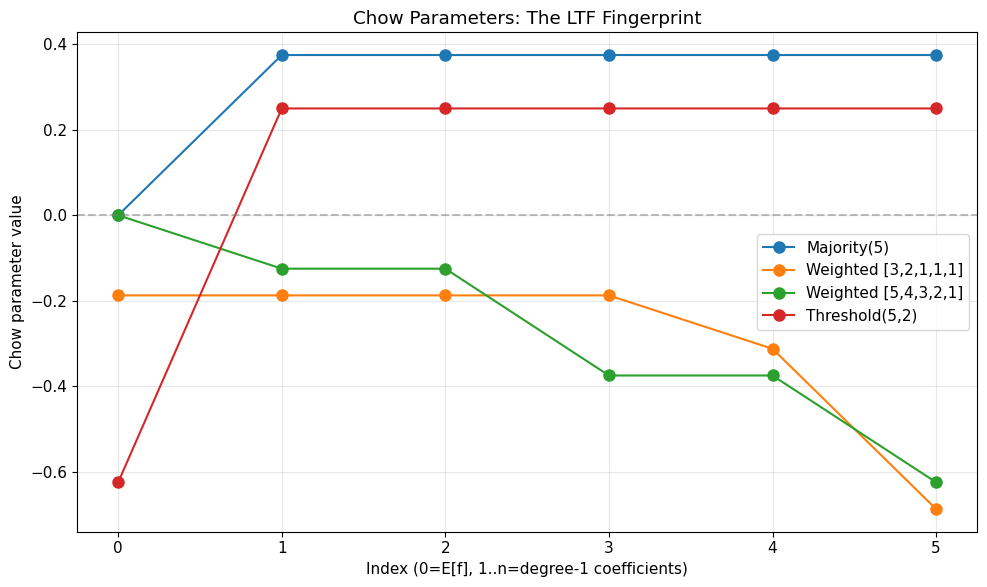

In [10]:
# Visualize Chow parameters
fig, ax = plt.subplots(figsize=(10, 6))

for ltf, name in ltfs:
    chow = chow_parameters(ltf)
    ax.plot(range(len(chow)), chow, 'o-', label=name, markersize=8)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Index (0=E[f], 1..n=degree-1 coefficients)')
ax.set_ylabel('Chow parameter value')
ax.set_title('Chow Parameters: The LTF Fingerprint')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 4. Regular vs Irregular LTFs

An LTF is **$\tau$-regular** if no single weight dominates:
$$\max_i |w_i| \leq \tau \cdot ||w||_2$$

**Regular LTFs** (small $\tau$):
- Behave like Majority
- Total influence $\approx \sqrt{n/\pi}$
- Central Limit Theorem applies

**Irregular LTFs** (large $\tau$):
- Behave like Dictators
- One variable dominates
- Low total influence

In [11]:
def compute_regularity(weights):
    """Compute regularity parameter tau."""
    w = np.array(weights, dtype=float)
    return np.max(np.abs(w)) / np.linalg.norm(w)

def analyze_regularity_spectrum(n=7):
    """Compare LTFs across the regularity spectrum."""
    # Create LTFs with varying regularity
    configurations = [
        ([1]*n, "Majority (most regular)"),
        ([2, 1, 1, 1, 1, 1, 1][:n], "Slightly weighted"),
        ([4, 2, 1, 1, 1, 1, 1][:n], "Moderately weighted"),
        ([8, 2, 1, 1, 1, 1, 1][:n], "Heavily weighted"),
        ([100] + [1]*(n-1), "Near-dictator (irregular)"),
    ]
    
    results = []
    for weights, name in configurations:
        ltf = bf.weighted_majority(weights)
        tau = compute_regularity(weights)
        total_inf = ltf.total_influence()
        max_inf = max(ltf.influences())
        results.append({
            'name': name,
            'tau': tau,
            'total_inf': total_inf,
            'max_inf': max_inf,
            'max_inf_ratio': max_inf / total_inf if total_inf > 0 else 0
        })
    
    return results

results = analyze_regularity_spectrum(n=7)

print(f"Regularity Analysis (n=7)")
print(f"Majority theory: I[f] ~ sqrt(2n/pi) = {np.sqrt(2*7/np.pi):.4f}")
print("=" * 70)
print(f"{'Configuration':<30} {'tau':>8} {'I[f]':>8} {'max Inf':>8} {'ratio':>8}")
print("-" * 70)
for r in results:
    print(f"{r['name']:<30} {r['tau']:>8.4f} {r['total_inf']:>8.4f} {r['max_inf']:>8.4f} {r['max_inf_ratio']:>8.4f}")

Regularity Analysis (n=7)
Majority theory: I[f] ~ sqrt(2n/pi) = 2.1110
Configuration                       tau     I[f]  max Inf    ratio
----------------------------------------------------------------------
Majority (most regular)          0.3780   2.1875   0.3125   0.1429
Slightly weighted                0.6325   1.9531   0.5469   0.2800
Moderately weighted              0.8000   1.6250   0.8125   0.5000
Heavily weighted                 0.9363   1.0000   1.0000   1.0000
Near-dictator (irregular)        0.9997   1.0000   1.0000   1.0000


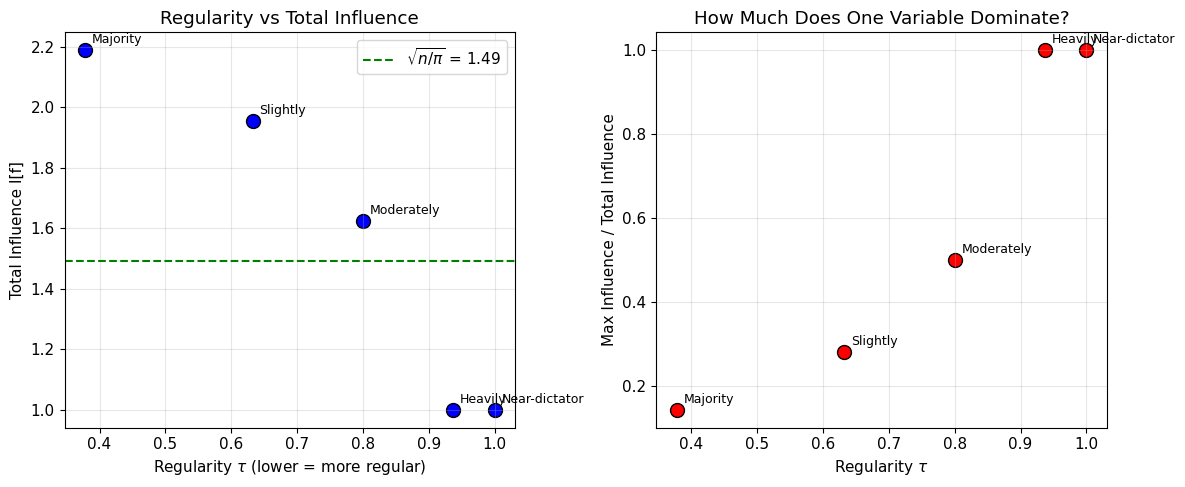

In [12]:
# Visualize regularity vs total influence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

taus = [r['tau'] for r in results]
total_infs = [r['total_inf'] for r in results]
max_inf_ratios = [r['max_inf_ratio'] for r in results]
names = [r['name'].split()[0] for r in results]  # Short names

# Plot 1: Regularity vs Total Influence
ax1.scatter(taus, total_infs, s=100, c='blue', edgecolors='black')
for i, name in enumerate(names):
    ax1.annotate(name, (taus[i], total_infs[i]), textcoords="offset points", 
                 xytext=(5,5), fontsize=9)
ax1.axhline(y=np.sqrt(7/np.pi), color='green', linestyle='--', 
            label=f'$\\sqrt{{n/\\pi}}$ = {np.sqrt(7/np.pi):.2f}')
ax1.set_xlabel('Regularity $\\tau$ (lower = more regular)')
ax1.set_ylabel('Total Influence I[f]')
ax1.set_title('Regularity vs Total Influence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Regularity vs Max Influence Ratio
ax2.scatter(taus, max_inf_ratios, s=100, c='red', edgecolors='black')
for i, name in enumerate(names):
    ax2.annotate(name, (taus[i], max_inf_ratios[i]), textcoords="offset points", 
                 xytext=(5,5), fontsize=9)
ax2.set_xlabel('Regularity $\\tau$')
ax2.set_ylabel('Max Influence / Total Influence')
ax2.set_title('How Much Does One Variable Dominate?')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 5. The Central Limit Theorem View

For an LTF $f(x) = \text{sign}(w \cdot x - \theta)$, the weighted sum $S = w \cdot x$ is a sum of independent random variables.

By CLT, for large $n$ and regular LTFs:
$$S = \sum_i w_i x_i \approx \mathcal{N}(0, ||w||_2^2)$$

This explains why regular LTFs have total influence $\approx \sqrt{2n/\pi}$.

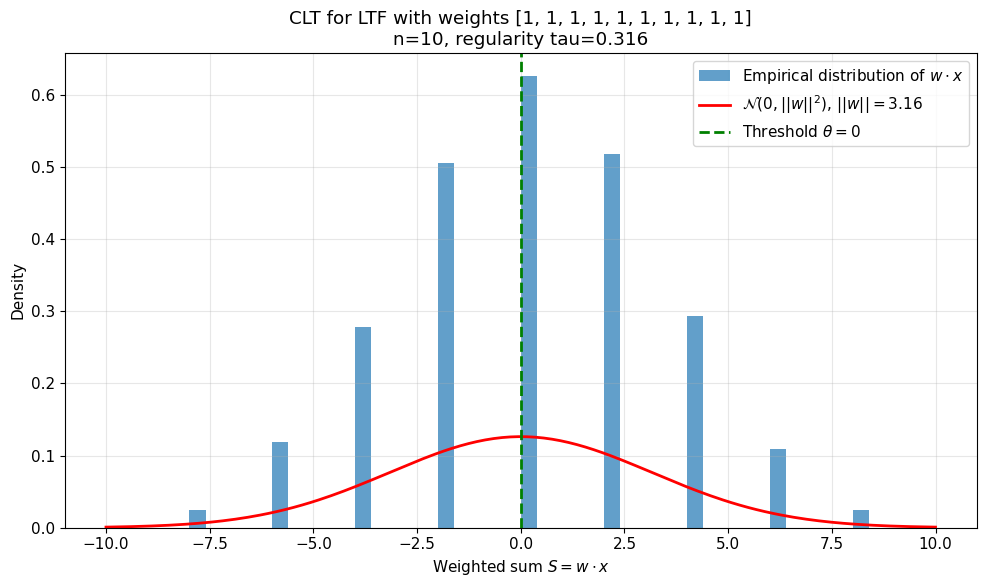

In [13]:
def visualize_clt_for_ltf(weights, n_samples=10000):
    """Visualize the CLT approximation for an LTF."""
    n = len(weights)
    w = np.array(weights, dtype=float)
    w_norm = np.linalg.norm(w)
    
    # Sample from {-1, +1}^n and compute weighted sums
    rng = np.random.default_rng(42)
    X = rng.choice([-1, 1], size=(n_samples, n))
    S = X @ w  # Weighted sums
    
    # Plot histogram vs Gaussian
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.hist(S, bins=50, density=True, alpha=0.7, label='Empirical distribution of $w \cdot x$')
    
    # Gaussian approximation
    x_range = np.linspace(S.min(), S.max(), 200)
    gaussian = np.exp(-x_range**2 / (2 * w_norm**2)) / (w_norm * np.sqrt(2 * np.pi))
    ax.plot(x_range, gaussian, 'r-', linewidth=2, label=f'$\\mathcal{{N}}(0, ||w||^2)$, $||w||={w_norm:.2f}$')
    
    # Mark threshold
    ax.axvline(x=0, color='green', linestyle='--', linewidth=2, label='Threshold $\\theta=0$')
    
    ax.set_xlabel('Weighted sum $S = w \cdot x$')
    ax.set_ylabel('Density')
    ax.set_title(f'CLT for LTF with weights {weights}\n'
                 f'n={n}, regularity tau={compute_regularity(weights):.3f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Regular LTF (majority)
visualize_clt_for_ltf([1]*10)
plt.show()

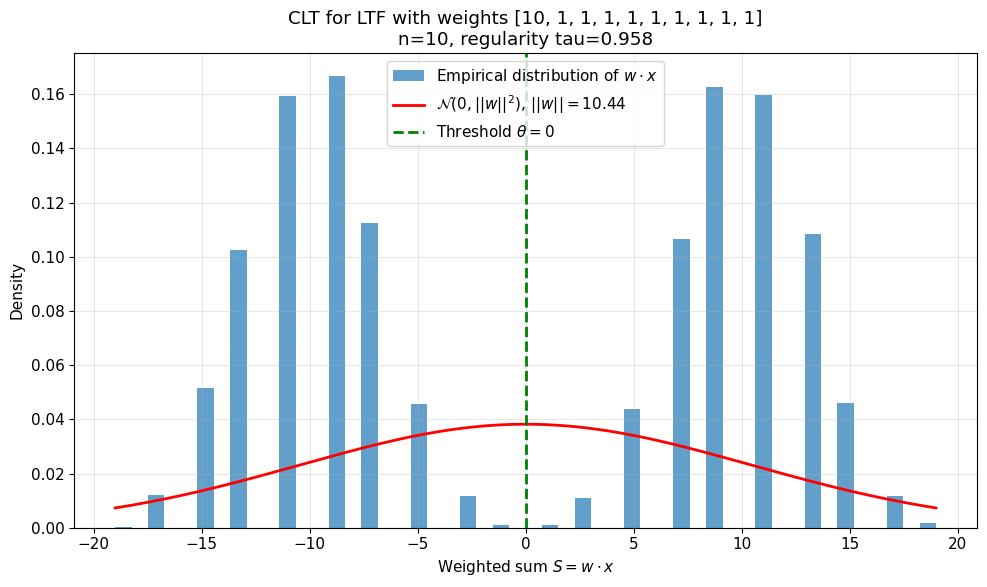

In [14]:
# Irregular LTF (near-dictator) - CLT fails
visualize_clt_for_ltf([10, 1, 1, 1, 1, 1, 1, 1, 1, 1])
plt.show()

---
## 6. Which Functions are LTFs?

Not all Boolean functions can be represented as LTFs!

**LTFs include**:
- AND, OR (threshold functions)
- Majority
- Dictator
- Any weighted voting scheme

**NOT LTFs**:
- XOR/Parity (no hyperplane can separate odd from even inputs)
- Most Boolean functions

In [15]:
from boofun.analysis.ltf_analysis import is_ltf

# Test which functions are LTFs
test_functions = [
    (bf.majority(5), "Majority(5)"),
    (bf.parity(5), "Parity(5) = XOR"),
    (bf.AND(5), "AND(5)"),
    (bf.OR(5), "OR(5)"),
    (bf.threshold(5, 2), "Threshold(5,2)"),
    (bf.dictator(5, 0), "Dictator(5,0)"),
    (bf.tribes(2, 3), "Tribes(2,3)"),
]

print("Is this function an LTF?")
print("=" * 40)
for f, name in test_functions:
    result = is_ltf(f)
    symbol = "Yes" if result else "No"
    print(f"{name:<25} {symbol}")

Is this function an LTF?
Majority(5)               Yes
Parity(5) = XOR           No
AND(5)                    Yes
OR(5)                     Yes
Threshold(5,2)            Yes
Dictator(5,0)             Yes
Tribes(2,3)               Yes


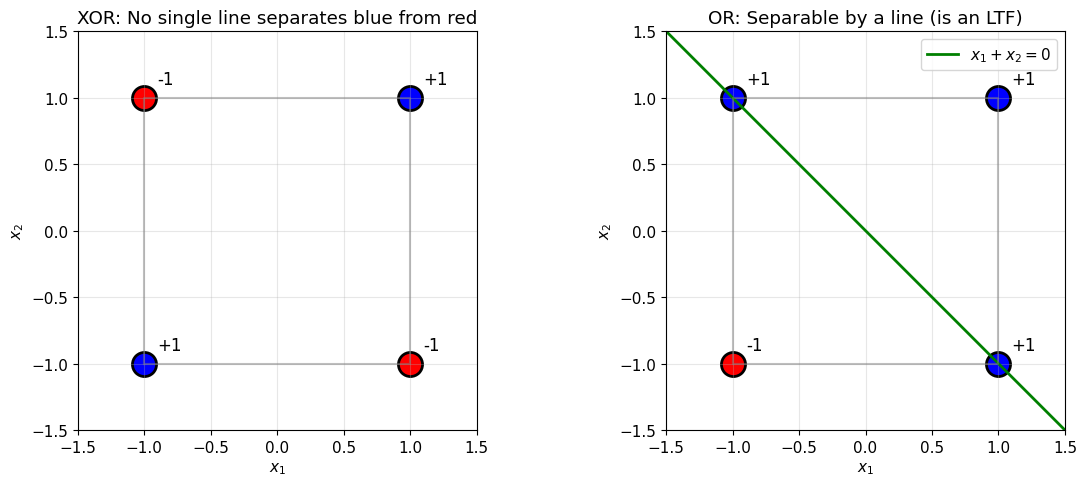

In [16]:
# Visualize why XOR is not an LTF (n=2 case)
fig = plt.figure(figsize=(12, 5))

# XOR truth table on {-1,+1}^2
ax1 = fig.add_subplot(121)
vertices = np.array([[-1,-1], [-1,1], [1,-1], [1,1]])
xor_values = np.array([1, -1, -1, 1])  # XOR in +/- encoding

for v, val in zip(vertices, xor_values):
    color = 'blue' if val > 0 else 'red'
    ax1.scatter(*v, c=color, s=300, edgecolors='black', linewidth=2)
    ax1.annotate(f'{int(val):+d}', (v[0]+0.1, v[1]+0.1), fontsize=12)

# Draw square
ax1.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'gray', alpha=0.5)
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_title('XOR: No single line separates blue from red')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Majority (IS an LTF)
ax2 = fig.add_subplot(122)
maj_values = np.array([-1, 1, 1, 1])  # Majority in +/- (threshold at 0)

for v, val in zip(vertices, maj_values):
    color = 'blue' if val > 0 else 'red'
    ax2.scatter(*v, c=color, s=300, edgecolors='black', linewidth=2)
    ax2.annotate(f'{int(val):+d}', (v[0]+0.1, v[1]+0.1), fontsize=12)

# Draw separating line: x1 + x2 = 0
ax2.plot([-1.5, 1.5], [1.5, -1.5], 'g-', linewidth=2, label='$x_1 + x_2 = 0$')
ax2.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'gray', alpha=0.5)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('OR: Separable by a line (is an LTF)')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

---
## 7. Real-World Example: Electoral College

The U.S. Electoral College is a weighted majority function where each state's weight equals its electoral votes. This is an LTF!

In [17]:
# Simplified Electoral College (top 10 states by electoral votes, 2024)
electoral_votes = {
    'CA': 54, 'TX': 40, 'FL': 30, 'NY': 28, 'PA': 19,
    'IL': 19, 'OH': 17, 'GA': 16, 'NC': 16, 'MI': 15
}

weights = list(electoral_votes.values())
states = list(electoral_votes.keys())
total_ev = sum(weights)
threshold = total_ev // 2 + 1  # Need majority to win

print(f"Simplified Electoral College (top 10 states)")
print(f"Total electoral votes: {total_ev}")
print(f"Threshold to win: {threshold}")
print()

# Create the LTF
electoral_ltf = bf.weighted_majority(weights, threshold)
infs = electoral_ltf.influences()

print("State Influences (probability of being pivotal):")
print("-" * 40)
for state, ev, inf in sorted(zip(states, weights, infs), key=lambda x: -x[2]):
    print(f"{state}: {ev:>2} electoral votes, influence = {inf:.4f}")

Simplified Electoral College (top 10 states)
Total electoral votes: 254
Threshold to win: 128

State Influences (probability of being pivotal):
----------------------------------------
CA: 54 electoral votes, influence = 0.1582
TX: 40 electoral votes, influence = 0.1348
FL: 30 electoral votes, influence = 0.1074
NY: 28 electoral votes, influence = 0.0840
PA: 19 electoral votes, influence = 0.0762
IL: 19 electoral votes, influence = 0.0762
OH: 17 electoral votes, influence = 0.0645
GA: 16 electoral votes, influence = 0.0566
NC: 16 electoral votes, influence = 0.0566
MI: 15 electoral votes, influence = 0.0566


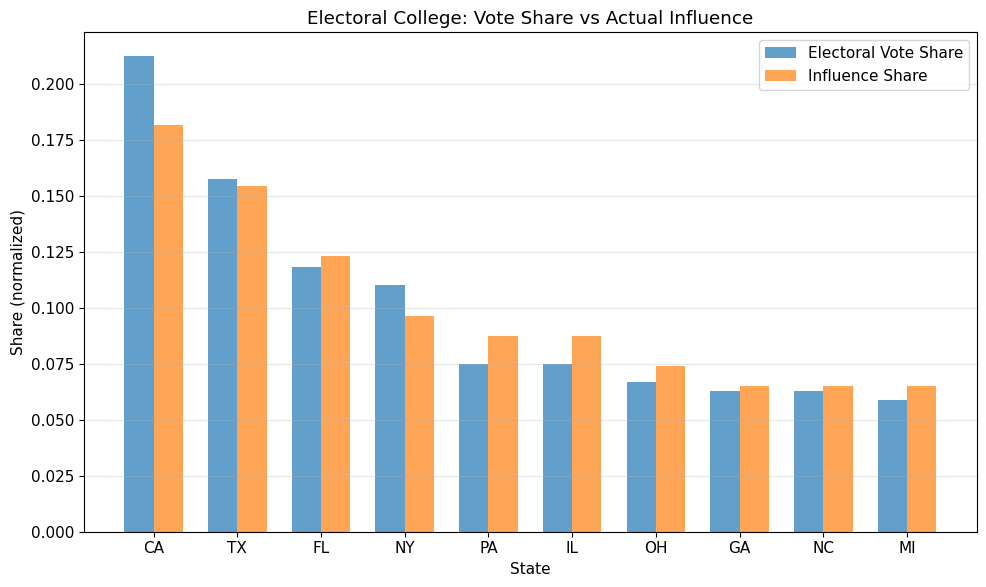


Note: Influence is more evenly distributed than raw vote share.
This is because smaller states can still be pivotal in close elections.


In [18]:
# Visualize electoral influence vs votes
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(states))
width = 0.35

# Normalize for comparison
weights_norm = np.array(weights) / sum(weights)
infs_norm = np.array(infs) / sum(infs)

bars1 = ax.bar(x - width/2, weights_norm, width, label='Electoral Vote Share', alpha=0.7)
bars2 = ax.bar(x + width/2, infs_norm, width, label='Influence Share', alpha=0.7)

ax.set_xlabel('State')
ax.set_ylabel('Share (normalized)')
ax.set_title('Electoral College: Vote Share vs Actual Influence')
ax.set_xticks(x)
ax.set_xticklabels(states)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nNote: Influence is more evenly distributed than raw vote share.")
print("This is because smaller states can still be pivotal in close elections.")

---
## 8. LTF Analysis Summary

Use the library's built-in LTF analysis for comprehensive reports.

In [19]:
# Full LTF analysis
weights_example = [5, 3, 2, 1, 1]
ltf = bf.weighted_majority(weights_example)

analysis = analyze_ltf(ltf)
print(analysis.summary())

LTF Analysis
Is LTF: True
Weights: [-2. -2. -4. -4. -8.]
Threshold: -11.0000
Chow params: [-0.125 -0.125 -0.125 -0.25  -0.25  -0.75 ]
Critical index: 1
Regularity τ: 0.7845


---
## Key Takeaways

1. **Geometric view**: LTFs are hyperplanes cutting the hypercube. Points on each side get different labels.

2. **Weights and influences**: Larger weights mean higher influence. The influence ordering matches the weight ordering.

3. **Chow uniqueness**: LTFs are uniquely determined by their Chow parameters (just $n+1$ numbers).

4. **Regularity**: Regular LTFs (no dominant weight) behave like Majority. Irregular LTFs behave like Dictators.

5. **CLT connection**: For regular LTFs, the weighted sum is approximately Gaussian, explaining their nice properties.

6. **Not everything is an LTF**: XOR/Parity cannot be represented as an LTF (no separating hyperplane exists).

---

**Further reading**: O'Donnell, Chapter 5 - "Threshold Functions"